In [1]:
import pandas as pd
from sklearn.model_selection import train_test_split
from catboost import Pool, CatBoostClassifier, CatBoostRegressor
import numpy as np

import plotly.graph_objects  as go

from sklearn.metrics import mean_absolute_error

import os
import re 
from tqdm import tqdm 

In [2]:
df = pd.read_csv('../data/frame2.csv')

c:\Users\maksk\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3071: DtypeWarning: Columns (48) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,


<AxesSubplot:>

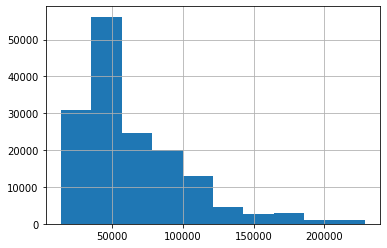

In [3]:
df['salary_from_rate_and_gross'].hist()

In [4]:
buckets = list(np.arange(-1, 250_000+10_000, 10_000)) + [np.inf]
buckets = pd.DataFrame(np.vstack([buckets[:-1], buckets[1:]])).T.values
# buckets
# buckets = pd.DataFrame(np.vstack([buckets[:-1], buckets[1:]])).T
# buckets.columns = ['from', 'to']

In [5]:
for bucket in buckets:
    df.loc[
        (df['salary_from_rate_and_gross'] > bucket[0])
            &
        (df['salary_from_rate_and_gross'] <= bucket[1])
    , 'label'] = f'[{bucket[0]}, {bucket[1]})'

In [6]:
df = df[
    (df['salary_from_rate_and_gross'] > 13_500) 
        &
    (df['salary_from_rate_and_gross'] < 230_000) 
]

In [47]:
features = [
    'billing_type',
    'schedule',
    'name',
    'area',
    'allow_messages',
    'experience',
    'accept_handicapped',
    'accept_kids',
    'employer',
    'accept_temporary',
    '15',
    'lat',
    'lng',
    'department_name',
    'has_department',
    'description_clear',
    'description_len',
    'uniq_skills_cnt',
    'uniq_popular_skills_cnt',
    'professional_roles_id',
    'dollar_rate',
    'is_engl',
    'is_ger',
    'is_chi',
    'cnt_lang',
    'label',
    # 'key_skills_embedding'
    
]
cat_features = [
    'billing_type',
    'schedule',
    'area',
    'experience',
    'employer',
    '15',
    'department_name',
    'professional_roles_id'
]
text_features = [
    'name',
    'description_clear'
]

# embeddings = [
#     'key_skills_embedding'
# ]

In [48]:
X_train, X_valid, y_train, y_valid = train_test_split(df[features].drop(['label'], axis=1), df['label'], test_size=0.3, random_state=0, stratify=df['label'])
X_valid, X_test, y_valid, y_test = train_test_split(X_valid, y_valid, test_size=0.5, random_state=0, stratify=y_valid)

In [49]:
pools = {}

pools['train'] = Pool(
    data=X_train,
    label=y_train,
    cat_features=cat_features,
    text_features=text_features,
    # embedding_features=embeddings
)


pools['valid'] = Pool(
    data=X_valid,
    label=y_valid,
    cat_features=cat_features,
    text_features=text_features,
    # embedding_features=embeddings
)


pools['test'] = Pool(
    data=X_test,
    label=y_test,
    cat_features=cat_features,
    text_features=text_features,
    # embedding_features=embeddings
)

In [52]:
model = CatBoostClassifier(iterations = 1_500, task_type='GPU')
model.fit(
    pools['train'],
    eval_set=pools['valid'],
    use_best_model=True,
    plot=False,
    verbose=50,
    early_stopping_rounds=50,
)

Learning rate set to 0.141591
0:	learn: 2.7428629	test: 2.7275901	best: 2.7275901 (0)	total: 287ms	remaining: 7m 10s
50:	learn: 1.8098924	test: 1.7729799	best: 1.7729799 (50)	total: 4.72s	remaining: 2m 14s
100:	learn: 1.7281892	test: 1.7059931	best: 1.7059931 (100)	total: 9.26s	remaining: 2m 8s
150:	learn: 1.6829458	test: 1.6766776	best: 1.6766776 (150)	total: 13.6s	remaining: 2m 1s
200:	learn: 1.6530139	test: 1.6598044	best: 1.6598044 (200)	total: 17.8s	remaining: 1m 55s
250:	learn: 1.6258046	test: 1.6463045	best: 1.6463045 (250)	total: 22.2s	remaining: 1m 50s
300:	learn: 1.6024450	test: 1.6363294	best: 1.6363294 (300)	total: 26.5s	remaining: 1m 45s
350:	learn: 1.5827622	test: 1.6290590	best: 1.6290590 (350)	total: 30.4s	remaining: 1m 39s
400:	learn: 1.5637071	test: 1.6231930	best: 1.6231930 (400)	total: 34.4s	remaining: 1m 34s
450:	learn: 1.5461196	test: 1.6177677	best: 1.6177677 (450)	total: 38.6s	remaining: 1m 29s
500:	learn: 1.5278796	test: 1.6113787	best: 1.6113787 (500)	total: 4

In [68]:
#importing confusion matrix
from sklearn.metrics import confusion_matrix
y_pred = model.predict(pools['test'])
confusion = confusion_matrix(y_test, y_pred)
print('Confusion Matrix\n')
print(confusion)

#importing accuracy_score, precision_score, recall_score, f1_score
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
print('\nAccuracy: {:.2f}\n'.format(accuracy_score(y_test, y_pred)))

print('Micro Precision: {:.2f}'.format(precision_score(y_test, y_pred, average='micro')))
print('Micro Recall: {:.2f}'.format(recall_score(y_test, y_pred, average='micro')))
print('Micro F1-score: {:.2f}\n'.format(f1_score(y_test, y_pred, average='micro')))

print('Macro Precision: {:.2f}'.format(precision_score(y_test, y_pred, average='macro')))
print('Macro Recall: {:.2f}'.format(recall_score(y_test, y_pred, average='macro')))
print('Macro F1-score: {:.2f}\n'.format(f1_score(y_test, y_pred, average='macro')))

print('Weighted Precision: {:.2f}'.format(precision_score(y_test, y_pred, average='weighted')))
print('Weighted Recall: {:.2f}'.format(recall_score(y_test, y_pred, average='weighted')))
print('Weighted F1-score: {:.2f}'.format(f1_score(y_test, y_pred, average='weighted')))

from sklearn.metrics import classification_report
print('\nClassification Report\n')
print(classification_report(y_test, y_pred))

Confusion Matrix

[[ 467   21   30    3    3   35    0    0    0    1    2    0    7   13
     7   84   52   99    7  125    0   42]
 [  54  105   23    5    3   11    0    2    0    0    1    0    2    4
     2   19   27   18    2   35    0   15]
 [  85   10  136    8    4   28    0    0    0    0    2    0    4    1
     1   27   21   39    3   45    0   11]
 [  29   11   15   77    3   13    1    2    0    0    1    0    3    1
     1   10    6   12    3   19    0    7]
 [  27   12   13    5   57   27    0    2    0    0    6    0    1    2
     0    8    5    4    3   16    0   13]
 [  78    4   20    6    6  173    0    2    0    1    8    0    8    3
     0   16    7   18    1   18    0    6]
 [   2    5    4    0    2    3    7    0    0    0    0    0    0    0
     0    4    0    0    0    1    0    0]
 [   8    3    3    5    3    5    0   22    0    1    0    0    2    0
     0    2    3    2    0    3    0    4]
 [   5    0    4    2    3    7    0    0   24    0    0    0 

In [111]:
city_mapping = pd.read_csv('../data/city_mapping.csv')
x = pd.read_csv('../data/dataset.csv')[['item_id', 'area_id']]
x.drop_duplicates(subset=['item_id'], inplace=True)
df = df.merge(x[['area_id', 'item_id']], how='left', on='item_id')
df = df.merge(city_mapping[['area_id', 'out']], how='left', on='area_id')
pathes = []
root = '../data/info-stat/'
for directory in os.listdir(root):
    for file in os.listdir(root + directory):
        # print(root + directory + '/' + file)
        pathes.append(root + directory + '/' + file)

df2 = pd.DataFrame(df['out'].unique(), columns=['out'])
for i, path in enumerate(pathes[:]):
    print(i, path)
    rosstat = pd.read_excel(path)
    columns = ['out'] + [f'feature_{i}{k}'for k in range(len(rosstat.columns[1:]))]
    rosstat.columns = columns
    rosstat = rosstat[columns].sort_values(columns).drop_duplicates(['out'], keep='first')
    rosstat['out'] = rosstat['out'].str.strip() # в некоторых колонках есть пробелы на конце
    rosstat['out'] = rosstat['out'].apply(
        lambda x: ' '.join(
            [re.sub(r'[0-9]', '', xx) for xx in x.split()]
            )
    )
    rosstat['out'] = rosstat['out'].str.replace(':', ',')
    for c in columns[1:]:
        rosstat[c] = rosstat[c].astype(str)
        rosstat[c] = pd.to_numeric(rosstat[c], errors='coerce')
    df2 = df2.merge(rosstat, on=['out'], how='left')
# df2 = df2.drop_duplicates(subset='out')
# new_features = list(df2.columns[1:])
# df = df.merge(df2, how='left', on = 'out')

Columns (49) have mixed types.Specify dtype option on import or set low_memory=False.


0 ../data/info-stat/01 промышленность/01-01 индекс промышленного производства.xls
1 ../data/info-stat/01 промышленность/01-02 добыча полезных ископаемых.xls
2 ../data/info-stat/01 промышленность/01-03 обрабатывающие производства.xls
3 ../data/info-stat/01 промышленность/01-04 обеспечение электр.энергией, газом и паром кондиционирование воздуха.xls
4 ../data/info-stat/01 промышленность/01-05 водоснабжение  водоотведение  организация сбора  и утилизация отходов.xls
5 ../data/info-stat/01 промышленность/01-06 отгрузка товаров.xls
6 ../data/info-stat/01 промышленность/01-07 отгрузка-Рыболовство, рыбоводство.xls
7 ../data/info-stat/01 промышленность/01-11 производство электроэнергии.xls
8 ../data/info-stat/02 сельское хозяйство/02-01 Индексы сельского хозяйства.xls
9 ../data/info-stat/03 строительство/03-01 объем работ выполненных по ВЭД Строительство.xlsx
10 ../data/info-stat/03 строительство/03-02 строительство жилых домов.xls
11 ../data/info-stat/04 транспорт/04-01 Перевозка грузов и гру

In [112]:
df2.columns

Index(['out', 'feature_00', 'feature_10', 'feature_20', 'feature_30',
       'feature_40', 'feature_50', 'feature_60', 'feature_70', 'feature_80',
       'feature_90', 'feature_100', 'feature_110', 'feature_120',
       'feature_130', 'feature_140', 'feature_150', 'feature_160',
       'feature_170', 'feature_180', 'feature_190', 'feature_200',
       'feature_210', 'feature_220', 'feature_230', 'feature_240',
       'feature_250', 'feature_260', 'feature_270', 'feature_280',
       'feature_290', 'feature_300', 'feature_310', 'feature_320',
       'feature_330', 'feature_340', 'feature_350', 'feature_360',
       'feature_370', 'feature_380', 'feature_390', 'feature_400',
       'feature_410', 'feature_411', 'feature_412', 'feature_413',
       'feature_414', 'feature_415', 'feature_420', 'feature_430',
       'feature_440', 'feature_450'],
      dtype='object')

In [109]:
df['15'].unique()

array(['Административный персонал', 'Автомобильный бизнес',
       'Высший и средний менеджмент', 'Безопасность', 'Добыча сырья',
       'Информационные технологии', 'Домашний, обслуживающий персонал',
       'Закупки', 'Искусство, развлечения, массмедиа',
       'Маркетинг, реклама, PR', 'Продажи, обслуживание клиентов',
       'Наука, образование', 'Медицина, фармацевтика',
       'Производство, сервисное обслуживание', 'Рабочий персонал',
       'Розничная торговля', 'Строительство, недвижимость',
       'Спортивные клубы, фитнес, салоны красоты',
       'Стратегия, инвестиции, консалтинг', 'Сельское хозяйство',
       'Страхование', 'Транспорт, логистика, перевозки',
       'Туризм, гостиницы, рестораны', 'Юристы',
       'Управление персоналом, тренинги', 'Другое',
       'Финансы, бухгалтерия'], dtype=object)

In [70]:
features = [
    'billing_type',
    'schedule',
    'name',
    'area',
    'allow_messages',
    'experience',
    'accept_handicapped',
    'accept_kids',
    'employer',
    'accept_temporary',
    '15',
    'lat',
    'lng',
    'department_name',
    'has_department',
    'description_clear',
    'description_len',
    'uniq_skills_cnt',
    'uniq_popular_skills_cnt',
    'professional_roles_id',
    'dollar_rate',
    'is_engl',
    'is_ger',
    'is_chi',
    'cnt_lang',
    'label',
    # 'key_skills_embedding'
] + new_features

cat_features = [
    'billing_type',
    'schedule',
    'area',
    'experience',
    'employer',
    '15',
    'department_name',
    'professional_roles_id'
]
text_features = [
    'name',
    'description_clear'
]

In [71]:
X_train, X_valid, y_train, y_valid = train_test_split(df[features].drop(['label'], axis=1), df['label'], test_size=0.3, random_state=0, stratify=df['label'])
X_valid, X_test, y_valid, y_test = train_test_split(X_valid, y_valid, test_size=0.5, random_state=0, stratify=y_valid)

In [72]:
pools = {}

pools['train'] = Pool(
    data=X_train,
    label=y_train,
    cat_features=cat_features,
    text_features=text_features,
    # embedding_features=embeddings
)


pools['valid'] = Pool(
    data=X_valid,
    label=y_valid,
    cat_features=cat_features,
    text_features=text_features,
    # embedding_features=embeddings
)


pools['test'] = Pool(
    data=X_test,
    label=y_test,
    cat_features=cat_features,
    text_features=text_features,
    # embedding_features=embeddings
)

In [73]:
model = CatBoostClassifier(iterations = 1_500, task_type='GPU')
model.fit(
    pools['train'],
    eval_set=pools['valid'],
    use_best_model=True,
    plot=False,
    verbose=50,
    early_stopping_rounds=50,
)

Learning rate set to 0.141591
0:	learn: 2.7371948	test: 2.7236173	best: 2.7236173 (0)	total: 289ms	remaining: 7m 13s
50:	learn: 1.7981897	test: 1.7667847	best: 1.7667847 (50)	total: 5.39s	remaining: 2m 33s
100:	learn: 1.7199808	test: 1.7031610	best: 1.7031610 (100)	total: 57.6s	remaining: 13m 17s
150:	learn: 1.6677007	test: 1.6678243	best: 1.6678243 (150)	total: 1m 42s	remaining: 15m 16s
200:	learn: 1.6360702	test: 1.6504402	best: 1.6504402 (200)	total: 2m 3s	remaining: 13m 21s
250:	learn: 1.6087629	test: 1.6379806	best: 1.6379806 (250)	total: 2m 54s	remaining: 14m 30s
300:	learn: 1.5857212	test: 1.6285818	best: 1.6285818 (300)	total: 3m 47s	remaining: 15m 5s
350:	learn: 1.5657607	test: 1.6205812	best: 1.6205812 (350)	total: 4m 14s	remaining: 13m 52s
400:	learn: 1.5474398	test: 1.6147479	best: 1.6147479 (400)	total: 5m	remaining: 13m 43s
450:	learn: 1.5277043	test: 1.6089931	best: 1.6089931 (450)	total: 5m 16s	remaining: 12m 16s
500:	learn: 1.5118856	test: 1.6043755	best: 1.6043755 (50

In [74]:
#importing confusion matrix
from sklearn.metrics import confusion_matrix
y_pred = model.predict(pools['test'])
confusion = confusion_matrix(y_test, y_pred)
print('Confusion Matrix\n')
print(confusion)

#importing accuracy_score, precision_score, recall_score, f1_score
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
print('\nAccuracy: {:.2f}\n'.format(accuracy_score(y_test, y_pred)))

print('Micro Precision: {:.2f}'.format(precision_score(y_test, y_pred, average='micro')))
print('Micro Recall: {:.2f}'.format(recall_score(y_test, y_pred, average='micro')))
print('Micro F1-score: {:.2f}\n'.format(f1_score(y_test, y_pred, average='micro')))

print('Macro Precision: {:.2f}'.format(precision_score(y_test, y_pred, average='macro')))
print('Macro Recall: {:.2f}'.format(recall_score(y_test, y_pred, average='macro')))
print('Macro F1-score: {:.2f}\n'.format(f1_score(y_test, y_pred, average='macro')))

print('Weighted Precision: {:.2f}'.format(precision_score(y_test, y_pred, average='weighted')))
print('Weighted Recall: {:.2f}'.format(recall_score(y_test, y_pred, average='weighted')))
print('Weighted F1-score: {:.2f}'.format(f1_score(y_test, y_pred, average='weighted')))

from sklearn.metrics import classification_report
print('\nClassification Report\n')
print(classification_report(y_test, y_pred))

Confusion Matrix

[[ 464   16   35    4    1   35    0    1    0    3    0    0    2   11
     5   85   61   87   10  134    0   44]
 [  56  108   15    9    2    9    0    0    0    0    0    0    0    2
     2   19   22   25    8   34    0   17]
 [  79   18  128    4    2   32    0    4    0    0    3    0    5    1
     4   18   19   42    3   47    0   16]
 [  34   11   13   73    4   13    0    2    0    0    0    0    1    1
     1    7    5   13    2   26    0    8]
 [  36   11   13    8   55   21    0    3    0    0    1    0    0    1
     0    7    4    5    2   21    0   13]
 [  72    6   17   10    4  175    0    3    0    2    9    0    9    1
     3   12    8   16    2   22    0    4]
 [   8    2    1    1    0    3    6    0    0    0    1    0    0    0
     0    2    1    0    0    2    0    1]
 [   8    2    7    4    1    7    0   19    0    1    1    0    3    0
     0    1    3    2    0    4    0    3]
 [   7    0    3    2    2    5    0    1   25    0    1    0 

In [75]:
array = []
with open('../data/similar_vac.txt', 'r') as f:
    raws = f.readlines()
    for raw in tqdm(raws):
        raw = raw.replace('\n', '')
        array.append(raw.split('\t'))
array = pd.DataFrame(array, columns=['item_id', 'mean_similar', 'min_similar', 'max_similar'])
array = array.astype(np.float64)
df = df.merge(array, on='item_id', how='left')

100%|██████████| 157044/157044 [00:00<00:00, 443527.53it/s]


In [76]:
features = [
    'billing_type',
    'schedule',
    'name',
    'area',
    'allow_messages',
    'experience',
    'accept_handicapped',
    'accept_kids',
    'employer',
    'accept_temporary',
    '15',
    'lat',
    'lng',
    'department_name',
    'has_department',
    'description_clear',
    'description_len',
    'uniq_skills_cnt',
    'uniq_popular_skills_cnt',
    'professional_roles_id',
    'dollar_rate',
    'is_engl',
    'is_ger',
    'is_chi',
    'cnt_lang',
    'label',
    # 'key_skills_embedding'
] + new_features + ['mean_similar', 'min_similar', 'max_similar']

cat_features = [
    'billing_type',
    'schedule',
    'area',
    'experience',
    'employer',
    '15',
    'department_name',
    'professional_roles_id'
]
text_features = [
    'name',
    'description_clear'
]

In [77]:
X_train, X_valid, y_train, y_valid = train_test_split(df[features].drop(['label'], axis=1), df['label'], test_size=0.3, random_state=0, stratify=df['label'])
X_valid, X_test, y_valid, y_test = train_test_split(X_valid, y_valid, test_size=0.5, random_state=0, stratify=y_valid)

In [78]:
pools = {}

pools['train'] = Pool(
    data=X_train,
    label=y_train,
    cat_features=cat_features,
    text_features=text_features,
    # embedding_features=embeddings
)


pools['valid'] = Pool(
    data=X_valid,
    label=y_valid,
    cat_features=cat_features,
    text_features=text_features,
    # embedding_features=embeddings
)


pools['test'] = Pool(
    data=X_test,
    label=y_test,
    cat_features=cat_features,
    text_features=text_features,
    # embedding_features=embeddings
)

In [79]:
model = CatBoostClassifier(iterations = 1_500, task_type='GPU')
model.fit(
    pools['train'],
    eval_set=pools['valid'],
    use_best_model=True,
    plot=False,
    verbose=50,
    early_stopping_rounds=50,
)

Learning rate set to 0.141591
0:	learn: 2.6197165	test: 2.6113747	best: 2.6113747 (0)	total: 130ms	remaining: 3m 15s
50:	learn: 1.5732040	test: 1.5489701	best: 1.5489701 (50)	total: 5.15s	remaining: 2m 26s
100:	learn: 1.4860278	test: 1.4715425	best: 1.4715425 (100)	total: 10.1s	remaining: 2m 20s
150:	learn: 1.4386073	test: 1.4372199	best: 1.4372199 (150)	total: 14.9s	remaining: 2m 12s
200:	learn: 1.4079278	test: 1.4179626	best: 1.4179626 (200)	total: 19.5s	remaining: 2m 5s
250:	learn: 1.3832377	test: 1.4054160	best: 1.4054160 (250)	total: 23.9s	remaining: 1m 58s
300:	learn: 1.3630044	test: 1.3956954	best: 1.3956954 (300)	total: 28.1s	remaining: 1m 51s
350:	learn: 1.3440637	test: 1.3881848	best: 1.3881848 (350)	total: 32.2s	remaining: 1m 45s
400:	learn: 1.3254375	test: 1.3818657	best: 1.3818657 (400)	total: 36.6s	remaining: 1m 40s
450:	learn: 1.3085046	test: 1.3765677	best: 1.3765677 (450)	total: 40.8s	remaining: 1m 34s
500:	learn: 1.2926768	test: 1.3716523	best: 1.3716523 (500)	total: 

In [80]:
#importing confusion matrix
from sklearn.metrics import confusion_matrix
y_pred = model.predict(pools['test'])
confusion = confusion_matrix(y_test, y_pred)
print('Confusion Matrix\n')
print(confusion)

#importing accuracy_score, precision_score, recall_score, f1_score
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
print('\nAccuracy: {:.2f}\n'.format(accuracy_score(y_test, y_pred)))

print('Micro Precision: {:.2f}'.format(precision_score(y_test, y_pred, average='micro')))
print('Micro Recall: {:.2f}'.format(recall_score(y_test, y_pred, average='micro')))
print('Micro F1-score: {:.2f}\n'.format(f1_score(y_test, y_pred, average='micro')))

print('Macro Precision: {:.2f}'.format(precision_score(y_test, y_pred, average='macro')))
print('Macro Recall: {:.2f}'.format(recall_score(y_test, y_pred, average='macro')))
print('Macro F1-score: {:.2f}\n'.format(f1_score(y_test, y_pred, average='macro')))

print('Weighted Precision: {:.2f}'.format(precision_score(y_test, y_pred, average='weighted')))
print('Weighted Recall: {:.2f}'.format(recall_score(y_test, y_pred, average='weighted')))
print('Weighted F1-score: {:.2f}'.format(f1_score(y_test, y_pred, average='weighted')))

from sklearn.metrics import classification_report
print('\nClassification Report\n')
print(classification_report(y_test, y_pred))

Confusion Matrix

[[ 551   20   48    6    3   35    0    0    0    0    0    0    2    4
     4   49   22   49    7  135    1   62]
 [  71  119   40   10    4   16    0    0    0    0    0    0    1    3
     1    9    7    5    4   20    0   18]
 [  92   29  168   12    6   42    0    0    0    0    0    0    2    2
     1   10    7   12    1   29    0   12]
 [  26   16   33   79   12   18    0    3    0    0    0    0    3    1
     0    3    3    4    1    7    0    5]
 [  25    9   22    7   67   45    0    2    0    0    2    0    4    0
     0    4    1    3    1    4    0    5]
 [  40    7   26    7   18  224    2    3    0    3    5    0   13    5
     0    5    3    1    1    5    0    7]
 [   3    5    0    1    1    8    5    0    2    0    3    0    0    0
     0    0    0    0    0    0    0    0]
 [   4    1    4    2    3   21    0   22    0    0    1    0    5    0
     0    1    0    0    0    0    0    2]
 [   3    0    1    0    3   18    0    0   25    0    1    0 

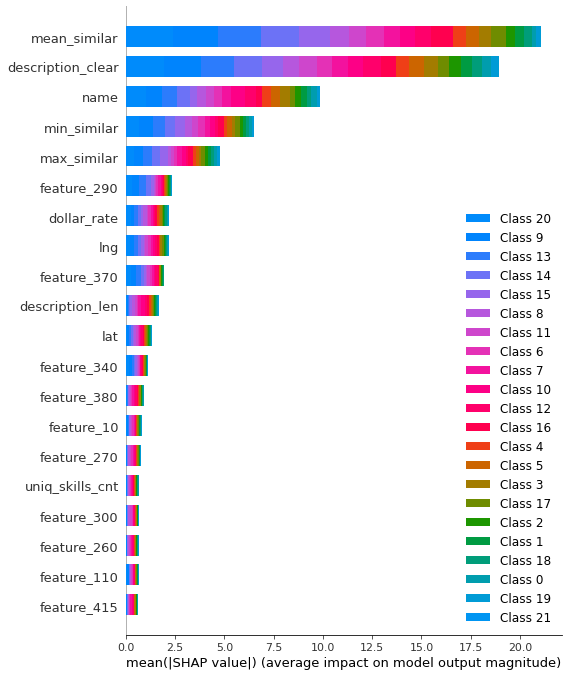

In [81]:
import shap
explainer = shap.TreeExplainer(model)
shap_values = explainer.shap_values(pools['test'])
shap.summary_plot(shap_values, X_test[model.feature_names_])

In [84]:
X_train

,description_clear
75845,обязанности регулярный обзвон менеджеров курир...
138619,обязанности приготовление заготовок соблюдение...
152966,приглашаем присоединиться к команде юридическо...
57118,в quotфедеральный мультисервисный центрquot тр...
98816,обязанности разъездной характер работы выполне...
...,...
153198,обязанности представление интересов в арбитраж...
104612,в ательестудию по пошиву одежды требуется адми...
101537,на производство развивающих комплексов и игруш...
120150,обязанности организация эффективной работы маг...


In [7]:
features = ['description_clear']
X_train, X_valid, y_train, y_valid = train_test_split(df[features], df['label'], test_size=0.3, random_state=0, stratify=df['label'])
X_valid, X_test, y_valid, y_test = train_test_split(X_valid, y_valid, test_size=0.5, random_state=0, stratify=y_valid)

pools = {}

pools['train'] = Pool(
    data=X_train,
    label=y_train,
    # cat_features=cat_features,
    text_features=['description_clear'],
    # embedding_features=embeddings
)


pools['valid'] = Pool(
    data=X_valid,
    label=y_valid,
    # cat_features=cat_features,
    text_features=['description_clear'],
    # embedding_features=embeddings
)


pools['test'] = Pool(
    data=X_test,
    label=y_test,
    # cat_features=cat_features,
    text_features=['description_clear'],
    # embedding_features=embeddings
)

model = CatBoostClassifier(iterations = 50, task_type='GPU')
model.fit(
    pools['train'],
    eval_set=pools['valid'],
    use_best_model=True,
    plot=False,
    verbose=50,
    early_stopping_rounds=50,
)

Learning rate set to 0.5
0:	learn: 2.4121338	test: 2.3550166	best: 2.3550166 (0)	total: 596ms	remaining: 29.2s
49:	learn: 1.8620273	test: 1.8794465	best: 1.8794465 (49)	total: 10.1s	remaining: 0us
bestTest = 1.879446473
bestIteration = 49


In [88]:
model.save_model('../app/model/base.cbm')

In [89]:
model_new = CatBoostClassifier().load_model('../app/model/base.cbm')

In [90]:
model.predict(pools['test'])

array([['[109999.0, 119999.0)'],
       ['[29999.0, 39999.0)'],
       ['[89999.0, 99999.0)'],
       ...,
       ['[129999.0, 139999.0)'],
       ['[109999.0, 119999.0)'],
       ['[49999.0, 59999.0)']], dtype=object)

In [91]:
model_new.predict(pools['test'])

array([['[109999.0, 119999.0)'],
       ['[29999.0, 39999.0)'],
       ['[89999.0, 99999.0)'],
       ...,
       ['[129999.0, 139999.0)'],
       ['[109999.0, 119999.0)'],
       ['[49999.0, 59999.0)']], dtype=object)

In [65]:
df.groupby('label')['item_id'].count().sort_values(ascending=False)

label
[49999.0, 59999.0)      26695
[29999.0, 39999.0)      25352
[39999.0, 49999.0)      21507
[59999.0, 69999.0)      17444
[69999.0, 79999.0)      12597
[19999.0, 29999.0)      12277
[89999.0, 99999.0)       8584
[109999.0, 119999.0)     6652
[99999.0, 109999.0)      5604
[79999.0, 89999.0)       4818
[129999.0, 139999.0)     2834
[9999.0, 19999.0)        2499
[159999.0, 169999.0)     2497
[119999.0, 129999.0)     2183
[139999.0, 149999.0)     1431
[149999.0, 159999.0)     1336
[219999.0, 229999.0)      874
[199999.0, 209999.0)      741
[179999.0, 189999.0)      441
[189999.0, 199999.0)      378
[169999.0, 179999.0)      185
[209999.0, 219999.0)      123
Name: item_id, dtype: int64

In [67]:
y_pred = ['[49999.0, 59999.0)' for _ in range(y_test.shape[0])]
#importing confusion matrix
from sklearn.metrics import confusion_matrix
# y_pred = model.predict(pools['test'])
confusion = confusion_matrix(y_test, y_pred)
print('Confusion Matrix\n')
print(confusion)

#importing accuracy_score, precision_score, recall_score, f1_score
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
print('\nAccuracy: {:.2f}\n'.format(accuracy_score(y_test, y_pred)))

print('Micro Precision: {:.2f}'.format(precision_score(y_test, y_pred, average='micro')))
print('Micro Recall: {:.2f}'.format(recall_score(y_test, y_pred, average='micro')))
print('Micro F1-score: {:.2f}\n'.format(f1_score(y_test, y_pred, average='micro')))

print('Macro Precision: {:.2f}'.format(precision_score(y_test, y_pred, average='macro')))
print('Macro Recall: {:.2f}'.format(recall_score(y_test, y_pred, average='macro')))
print('Macro F1-score: {:.2f}\n'.format(f1_score(y_test, y_pred, average='macro')))

print('Weighted Precision: {:.2f}'.format(precision_score(y_test, y_pred, average='weighted')))
print('Weighted Recall: {:.2f}'.format(recall_score(y_test, y_pred, average='weighted')))
print('Weighted F1-score: {:.2f}'.format(f1_score(y_test, y_pred, average='weighted')))

from sklearn.metrics import classification_report
print('\nClassification Report\n')
print(classification_report(y_test, y_pred))

Confusion Matrix

[[   0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0  998    0    0    0    0    0    0]
 [   0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0  328    0    0    0    0    0    0]
 [   0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0  425    0    0    0    0    0    0]
 [   0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0  214    0    0    0    0    0    0]
 [   0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0  201    0    0    0    0    0    0]
 [   0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0  375    0    0    0    0    0    0]
 [   0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0   28    0    0    0    0    0    0]
 [   0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0   66    0    0    0    0    0    0]
 [   0    0    0    0    0    0    0    0    0    0    0    0 

c:\Users\maksk\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Macro Precision: 0.01
Macro Recall: 0.05
Macro F1-score: 0.01


c:\Users\maksk\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))



Weighted Precision: 0.03
Weighted Recall: 0.17
Weighted F1-score: 0.05

Classification Report



c:\Users\maksk\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\maksk\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


                      precision    recall  f1-score   support

[109999.0, 119999.0)       0.00      0.00      0.00       998
[119999.0, 129999.0)       0.00      0.00      0.00       328
[129999.0, 139999.0)       0.00      0.00      0.00       425
[139999.0, 149999.0)       0.00      0.00      0.00       214
[149999.0, 159999.0)       0.00      0.00      0.00       201
[159999.0, 169999.0)       0.00      0.00      0.00       375
[169999.0, 179999.0)       0.00      0.00      0.00        28
[179999.0, 189999.0)       0.00      0.00      0.00        66
[189999.0, 199999.0)       0.00      0.00      0.00        56
  [19999.0, 29999.0)       0.00      0.00      0.00      1841
[199999.0, 209999.0)       0.00      0.00      0.00       111
[209999.0, 219999.0)       0.00      0.00      0.00        18
[219999.0, 229999.0)       0.00      0.00      0.00       131
  [29999.0, 39999.0)       0.00      0.00      0.00      3803
  [39999.0, 49999.0)       0.00      0.00      0.00      3226
  [4999

c:\Users\maksk\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [101]:
def get_features(url: str) -> pd.DataFrame:
    id = re.findall('[0-9]+', url) 
    return id
get_features('https://hh.ru/vacancy/78041387')

['78041387']

In [105]:
df.loc[137543]

item_id                                                         76085328
company_vacancies_url    https://api.hh.ru/vacancies?employer_id=4688557
item_url                                  https://hh.ru/vacancy/76085328
has_premium                                                            0
billing_type                                                    Стандарт
                                              ...                       
feature_440                                                      376.397
feature_450                                                       1644.6
mean_similar                                               124981.176471
min_similar                                                      70000.0
max_similar                                                     220000.0
Name: 137543, Length: 127, dtype: object

In [104]:
X_test

,description_clear
137543,обратите внимание что место работы московская ...
105370,stanгруппа – крупнейший в россии производитель...
82114,в связи с активным развитием продаж и делением...
2505,после отклика на вакансию вам приходит сообщен...
106277,обязанности погрузоразгрузочные работы с крано...
...,...
106825,обязанности прием тмц по количеству и качеству...
96599,обязанности руководство производственной деяте...
130427,обязанности контроль за безопасным производств...
22401,салоны 13 by timati это сеть салонов красоты к...


In [103]:
x = {
    '1': [2]
}
pd.DataFrame(x)

,1
0,2


In [94]:
import requests

requests.get('https://api.hh.ru/vacancies/78041387').json()

{'id': '78041387',
 'premium': True,
 'billing_type': {'id': 'premium', 'name': 'Премиум'},
 'relations': [],
 'name': 'Курьер легких заказов до 2 кг. (СРОЧНО - ежедневная оплата) можно работать с Iphone',
 'insider_interview': None,
 'response_letter_required': False,
 'area': {'id': '1', 'name': 'Москва', 'url': 'https://api.hh.ru/areas/1'},
 'salary': {'from': 87227, 'to': 136233, 'currency': 'RUR', 'gross': True},
 'type': {'id': 'open', 'name': 'Открытая'},
 'address': None,
 'allow_messages': True,
 'experience': {'id': 'noExperience', 'name': 'Нет опыта'},
 'schedule': {'id': 'flexible', 'name': 'Гибкий график'},
 'employment': {'id': 'part', 'name': 'Частичная занятость'},
 'department': None,
 'contacts': None,
 'description': '<p><strong>Курьер легких заказов до 2кг. (СРОЧНО - ежедневная оплата) можно работать с Iphone (на подработку). </strong></p> <p><em>Доставка только по микрорайону у дома. Вы только доставляете. Курьер может работать на чем угодно, и когда угодно! <stron

In [58]:
explainer = shap.TreeExplainer(model)
shap_values = explainer.shap_values(pools['test'])

In [106]:
test_objects = [X_test[features].iloc[0:1], X_test[features].iloc[91:92]]

for obj in test_objects:
    x1 = model.predict_proba(obj)[0]
    print(model.predict_proba(obj)[0])
    x2 = model.predict(obj, prediction_type='RawFormulaVal')[0]
    print(model.predict(obj, prediction_type='RawFormulaVal')[0])
    # print('Probability of class 1 = {:.4f}'.format(model.predict_proba(obj)[0][1]))
    # print('Formula raw prediction = {:.4f}'.format(model.predict(obj, prediction_type='RawFormulaVal')[0]))
    # print('\n')

[0.21703592 0.03303026 0.1090165  0.04630688 0.01792133 0.11283778
 0.00463917 0.00565985 0.00386362 0.00387319 0.01787143 0.0015642
 0.03450705 0.01680076 0.01618704 0.06021071 0.04820458 0.04887351
 0.03119014 0.08303157 0.00122568 0.08614885]
[ 0.92398625 -0.95865252  0.2354226  -0.62078604 -1.57008517  0.2698746
 -2.92154178 -2.72267898 -3.10447303 -3.1019977  -1.57287349 -4.00870444
 -0.9149129  -1.63465223 -1.6718654  -0.35822639 -0.58062259 -0.56684102
 -1.01597472 -0.03685567 -4.2525818   0.        ]
[0.12150368 0.04471048 0.08884739 0.03534671 0.04031849 0.08597432
 0.00327886 0.00303329 0.00740513 0.00163463 0.04800539 0.00202178
 0.07651497 0.00775106 0.01337049 0.01810759 0.04096485 0.03834243
 0.03194003 0.22046243 0.00074478 0.06972122]
[ 0.5554398  -0.44429686  0.2424154  -0.67929951 -0.5476946   0.20954387
 -3.05700773 -3.13485735 -2.24233231 -3.75309023 -0.37319148 -3.54052592
  0.09298163 -2.19667546 -1.65145491 -1.34817349 -0.53179033 -0.59794769
 -0.78064455  1.1512

In [107]:
np.exp(x2) / np.sum(np.exp(x2), axis=0)

array([0.12150368, 0.04471048, 0.08884739, 0.03534671, 0.04031849,
       0.08597432, 0.00327886, 0.00303329, 0.00740513, 0.00163463,
       0.04800539, 0.00202178, 0.07651497, 0.00775106, 0.01337049,
       0.01810759, 0.04096485, 0.03834243, 0.03194003, 0.22046243,
       0.00074478, 0.06972122])

In [104]:
arr = np.exp(x2) / (1 + np.exp(x2))
print(arr)
(arr / arr.sum())
x1.sum()

[0.63539674 0.39071759 0.5603088  0.33641766 0.36639944 0.55219512
 0.04491589 0.0416921  0.09601292 0.0229081  0.40777007 0.02818088
 0.52322867 0.10004943 0.16091241 0.20616915 0.37009942 0.35481337
 0.31418099 0.75973414 0.01056935 0.5       ]


1.0

In [89]:
1 / (1 + np.exp(-0.92398625))

0.7158536348879766

In [72]:
explainer.expected_value

[-0.07707517054014354,
 -1.344303053353384,
 -1.156568565025804,
 -2.162723551809481,
 -1.9772452310759996,
 -1.5489932343117507,
 -4.063500515682733,
 -3.3582604705779953,
 -3.8155604072585496,
 0.41820647874627925,
 -2.8746887036516036,
 -4.833904447277379,
 -2.716493440587856,
 1.6652516694510566,
 1.7809027984412338,
 2.103265026375014,
 1.6533473122450517,
 1.2193398115051415,
 0.18776365957863145,
 0.6155487634975548,
 -1.5687954749610344,
 0.0]

In [82]:
X_test[features].iloc[0,:]

description_clear    обратите внимание что место работы московская ...
Name: 137543, dtype: object

In [90]:
shap_values[0][0]

array([1.00106142])

In [92]:
shap.force_plot(explainer.expected_value[0], shap_values[0][0], features)

0.41.0


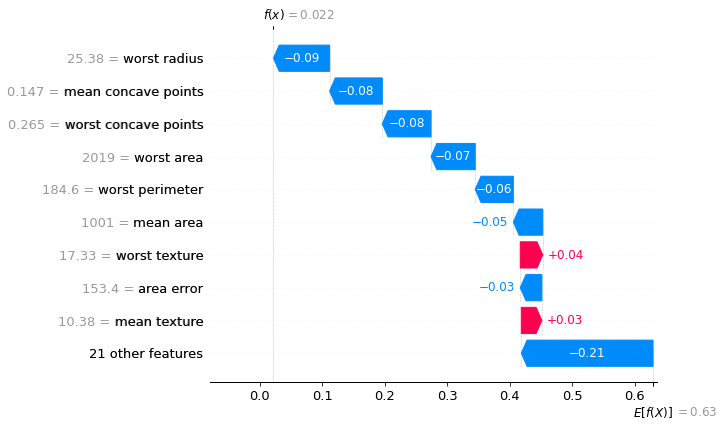

In [179]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.datasets import load_breast_cancer
from shap import TreeExplainer, Explanation
from shap.plots import waterfall

import shap
print(shap.__version__)

X, y = load_breast_cancer(return_X_y=True, as_frame=True)
m = RandomForestClassifier(max_depth=5, n_estimators=100).fit(X, y)
explainer = TreeExplainer(m)
sv = explainer(X)
exp = Explanation(sv.values[:,:,1], 
                  sv.base_values[:,1], 
                  data=X.values, 
                  feature_names=X.columns)
idx = 0
waterfall(exp[idx])

In [17]:
X_test

,description_clear
137543,обратите внимание что место работы московская ...
105370,stanгруппа – крупнейший в россии производитель...
82114,в связи с активным развитием продаж и делением...
2505,после отклика на вакансию вам приходит сообщен...
106277,обязанности погрузоразгрузочные работы с крано...
...,...
106825,обязанности прием тмц по количеству и качеству...
96599,обязанности руководство производственной деяте...
130427,обязанности контроль за безопасным производств...
22401,салоны 13 by timati это сеть салонов красоты к...


In [12]:
shap_values[0]

array([[-2.17254458e-02],
       [-2.02696059e-02],
       [-3.95560476e-02],
       [ 1.31191220e-01],
       [ 3.34287387e-02],
       [-3.92390509e-02],
       [ 3.44162707e-02],
       [-2.12979101e-02],
       [-3.53726194e-02],
       [-3.38409187e-02],
       [-3.82380650e-02],
       [ 2.90780048e-02],
       [ 3.38796169e-02],
       [-1.27367771e-02],
       [-3.08277182e-02],
       [ 2.28975397e-01],
       [-3.52158549e-02],
       [-3.51071798e-02],
       [-2.13370086e-02],
       [-1.85972250e-02],
       [ 8.11787533e-02],
       [-3.02061671e-02],
       [-3.12033960e-02],
       [ 2.37495411e-02],
       [-3.51706623e-02],
       [ 7.16415042e-03],
       [-3.80866791e-02],
       [-9.58262341e-03],
       [-7.01984186e-03],
       [ 7.05053511e-02],
       [-4.61663854e-03],
       [-3.86265722e-02],
       [-2.80365186e-02],
       [-3.58919315e-02],
       [-3.99111669e-02],
       [-3.97685568e-02],
       [-2.34807218e-02],
       [-4.01941791e-02],
       [-9.8

In [45]:
shap_values.shape

(23558, 1, 22)

In [47]:
to_pass

namespace(values=array([1.00106142]),
          data=array(<catboost.core.Pool object at 0x0000013A3D7F4E20>, dtype=object),
          feature_names=['description_clear'],
          base_values=-0.07707517054014354)

In [56]:
shap_values

.values =
array([[[ 1.00106142e+00,  3.85650530e-01,  1.39199117e+00, ...,
         -6.52404433e-01, -2.68378632e+00,  7.46850324e-17]],

       [[-1.05185210e+00,  4.39732407e-01, -7.00992088e-01, ...,
         -7.49965657e-01,  5.23983878e-01,  8.98357321e-17]],

       [[-9.34384399e-01,  1.51887351e-01,  5.44195723e-01, ...,
         -8.84782482e-01, -4.59319922e+00,  1.16227505e-16]],

       ...,

       [[ 1.03308526e+00,  9.71185450e-01,  2.45947885e+00, ...,
         -9.17725742e-01, -5.92393531e+00,  1.15611165e-16]],

       [[ 8.14294445e-01,  4.14901471e-01,  7.01731749e-01, ...,
         -3.26108447e-02, -3.39314174e+00,  1.79029542e-16]],

       [[-8.15003214e-01, -7.16608441e-01, -7.39373581e-01, ...,
          3.52431800e-02, -1.53467357e-02,  1.00792355e-16]]])

.base_values =
array([[-0.07707517, -1.34430305, -1.15656857, ...,  0.61554876,
        -1.56879547,  0.        ],
       [-0.07707517, -1.34430305, -1.15656857, ...,  0.61554876,
        -1.56879547,  0.    

In [57]:
from types import SimpleNamespace

explainer = shap.TreeExplainer(model)
shap_values = explainer(pools['test'])

to_pass = SimpleNamespace(**{
                          'values': np.array(shap_values[0].values[:,0]),
                          'data': np.array(shap_values[0].data),
                          'feature_names': features,
                          'base_values': shap_values[0].base_values[0]
            })

shap.plots.waterfall(to_pass)

# to_pass = SimpleNamespace(**{
#                           'values': np.array(shap_values[0].values[:,1]),
#                           'data': np.array(shap_values[0].data),
#                           'feature_names': features,
#                           'base_values': shap_values[0].base_values[0]
#             })

# shap.plots.waterfall(to_pass)

AttributeError: 'types.SimpleNamespace' object has no attribute 'display_data'

In [18]:
import catboost
q = model.get_feature_importance(pools['test'], type=catboost.EFstrType.ShapValues)

In [33]:
import catboost
q = model.get_feature_importance(pools['test'], type=catboost.EFstrType.ShapValues)

In [40]:
q[0][:, 1]

array([-0.07707517, -1.34430305, -1.15656857, -2.16272355, -1.97724523,
       -1.54899323, -4.06350052, -3.35826047, -3.81556041,  0.41820648,
       -2.8746887 , -4.83390445, -2.71649344,  1.66525167,  1.7809028 ,
        2.10326503,  1.65334731,  1.21933981,  0.18776366,  0.61554876,
       -1.56879547,  0.        ])

In [28]:
q[0]

array([[ 1.00106142e+00, -7.70751705e-02],
       [ 3.85650530e-01, -1.34430305e+00],
       [ 1.39199117e+00, -1.15656857e+00],
       [ 1.54193752e+00, -2.16272355e+00],
       [ 4.07160059e-01, -1.97724523e+00],
       [ 1.81886784e+00, -1.54899323e+00],
       [ 1.14195873e+00, -4.06350052e+00],
       [ 6.35581490e-01, -3.35826047e+00],
       [ 7.11087382e-01, -3.81556041e+00],
       [-3.52020418e+00,  4.18206479e-01],
       [ 1.30181521e+00, -2.87468870e+00],
       [ 8.25200012e-01, -4.83390445e+00],
       [ 1.80158054e+00, -2.71649344e+00],
       [-3.29990390e+00,  1.66525167e+00],
       [-3.45276820e+00,  1.78090280e+00],
       [-2.46149141e+00,  2.10326503e+00],
       [-2.23396990e+00,  1.65334731e+00],
       [-1.78618083e+00,  1.21933981e+00],
       [-1.20373838e+00,  1.87763660e-01],
       [-6.52404433e-01,  6.15548763e-01],
       [-2.68378632e+00, -1.56879547e+00],
       [ 7.46850324e-17,  0.00000000e+00]])

In [27]:
q[:, :, 1].argmax(axis=1)

array([15, 15, 15, ..., 15, 15, 15], dtype=int64)

In [14]:
masker = shap.maskers.Independent(X_test[features], 100)
explainer = KernelExplainer(model.predict_proba, data=masker.data)
shap_values = explainer.shap_values(masker.data)
shap_values

100%|██████████| 100/100 [00:00<00:00, 1605.24it/s]


[array([[-2.17254458e-02],
        [-2.02696059e-02],
        [-3.95560476e-02],
        [ 1.31191220e-01],
        [ 3.34287387e-02],
        [-3.92390509e-02],
        [ 3.44162707e-02],
        [-2.12979101e-02],
        [-3.53726194e-02],
        [-3.38409187e-02],
        [-3.82380650e-02],
        [ 2.90780048e-02],
        [ 3.38796169e-02],
        [-1.27367771e-02],
        [-3.08277182e-02],
        [ 2.28975397e-01],
        [-3.52158549e-02],
        [-3.51071798e-02],
        [-2.13370086e-02],
        [-1.85972250e-02],
        [ 8.11787533e-02],
        [-3.02061671e-02],
        [-3.12033960e-02],
        [ 2.37495411e-02],
        [-3.51706623e-02],
        [ 7.16415042e-03],
        [-3.80866791e-02],
        [-9.58262341e-03],
        [-7.01984186e-03],
        [ 7.05053511e-02],
        [-4.61663854e-03],
        [-3.86265722e-02],
        [-2.80365186e-02],
        [-3.58919315e-02],
        [-3.99111669e-02],
        [-3.97685568e-02],
        [-2.34807218e-02],
 

100%|██████████| 100/100 [00:00<00:00, 1960.76it/s]


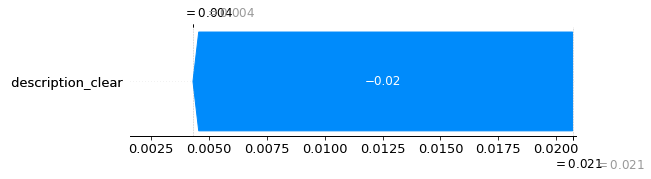

In [10]:
from shap import KernelExplainer, TreeExplainer
import matplotlib.pyplot as plt
import shap
# shap.initjs()
masker = shap.maskers.Independent(X_test[features], 100)
explainer = KernelExplainer(model.predict_proba, data=masker.data)
shap_values = explainer.shap_values(masker.data)

exp = Explanation(sv, explainer.expected_value, data=X.loc[[idx]].values, feature_names=X.columns)
waterfall(exp[0])

shap.plots._waterfall.waterfall_legacy(explainer.expected_value[2], shap_values[2][0], X_test[features].values[0], features, max_display=1)

In [133]:
explainer.expected_value[0]

0.045497728699917216

In [132]:
shap_values[0][0]

array([-0.02721347])

In [131]:
model.predict_proba(pools['test'])[0]

array([5.19597348e-01, 2.14131082e-02, 1.26484389e-01, 2.50725429e-02,
       4.44598496e-03, 1.65182305e-02, 7.67205748e-04, 6.22154274e-04,
       2.10265497e-03, 7.31929432e-04, 1.97546135e-03, 9.60493492e-05,
       2.18286806e-02, 4.14182146e-03, 1.32887063e-02, 4.05638411e-02,
       3.05449202e-02, 5.48793174e-02, 1.50982837e-02, 4.72727108e-02,
       1.38547425e-04, 5.24161125e-02])

In [138]:
import xgboost
import shap

# train XGBoost model
X,y = shap.datasets.adult()
model = xgboost.XGBClassifier().fit(X, y)

# compute SHAP values
explainer = shap.Explainer(model, X)
shap_values = explainer(X)

 99%|===================| 32349/32561 [01:16<00:00]        

In [143]:
type(shap_values)

shap._explanation.Explanation

In [ ]:
shap_values

In [113]:
shap_values[0].shape

(100, 1)

In [109]:
pd.DataFrame(model.predict(X_test[features]))[0].unique().__len__()

22

In [100]:
explainer.expected_value.shape

(22,)

In [85]:
from shap import KernelExplainer
import shap
shap.initjs()
masker = shap.maskers.Independent(X_test[features], 10)
ke = KernelExplainer(model.predict_proba, data=masker.data)
shap_values=ke.shap_values(masker.data)
shap.force_plot(ke.expected_value[1], shap_values[1][1])

100%|██████████| 10/10 [00:00<00:00, 999.76it/s]


In [86]:
shap_values[1][1]

array([-0.00602942])

In [39]:
# shap.plots._waterfall.waterfall_legacy(ke.expected_value, shap_values[0])
shap.waterfall_plot(ke.expected_value[0], shap_values, X_test.iloc[0])

AttributeError: 'numpy.float64' object has no attribute 'base_values'

In [37]:
shap_values[0][0]

array([-0.00039424])

In [28]:
ke.expected_value.shape

(22,)

In [24]:
shap_values.__len__() # - т.е для каждого класс какая то фигня

22

In [25]:
shap_values[0].shape

(2, 1)

In [26]:
masker.data.shape

(2, 1)